In [1]:
import sys,os
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import vaex
import astropy.units as u
import scipy.stats

In [16]:
from astropy.io import ascii

In [20]:
sys.path.append('./')

In [2]:
from astroquery.ipac.irsa import Irsa
from astropy.coordinates import SkyCoord
from astropy import units as u

Irsa.ROW_LIMIT = 100000

###Create a table of unWISE sources within the PHATTER footprint
wise = Irsa.query_region("m33", catalog="unwise_2019", spatial="Polygon",
            polygon=[SkyCoord(ra=23.34,dec=30.488,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=23.663,dec=30.488,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=23.663,dec=30.85,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=23.34,dec=30.85,unit=(u.deg,u.deg),frame='icrs')])

In [3]:
cut, = np.where(wise['primary'] == 1)
uw = wise[cut]

In [4]:
###Remove entries with no W1 flux measurement

uw2 = uw.filled(fill_value=0)
unwise = uw2[uw2['flux_1'] != 0]

In [5]:
###Convert flux measurements to W1 magnitude

def unwise_to_mag(flux):
  mag = 22.5 - 2.5 * np.log10(flux)
  return mag

In [6]:
###For sources with W2 flux measurements, convert flux to W2 magnitude

w2_mags = []

for source in unwise['flux_2']:
    if source != 0.0:
        mag = unwise_to_mag(source)
    else:
        mag = -9999.999
    
    w2_mags.append(mag)

In [7]:
###Add columns to data with W1 and W2 (where available) magnitudes

unwise['w1_mag'] = unwise_to_mag(unwise['flux_1'])
unwise['w2_mag'] = w2_mags

In [12]:
###Create a dataframe of PHATTER sources
###F110W–F160W> 1.2 and above the line
###(F160W) = 2 × (F110W − F160W) + 16.88 mag,
###Color and magnitude cuts from Goldman et al, 2021

phatter = vaex.open('/Users/tatianasandford/Documents/M33_Research/M33_full_matched.hdf5')
phatter.select('(F110W_SNR > 4) & (F110W_SHARP**2 < 0.15) & '
          '(F110W_CROWD < 2.25) & '
          '(F160W_SNR > 4) & (F160W_SHARP**2 < 0.15) & '
          '(F160W_CROWD < 2.25)', name='IR_GST')

In [22]:
phatter.select('(((F160W_VEGA < 19.48) & (F110W_VEGA - F160W_VEGA < 1.15)) | '
               '((F110W_VEGA - F160W_VEGA >= 1.15) & (F160W_VEGA < 2 * (F110W_VEGA - F160W_VEGA) + 17.18))) &'
               'IR_GST', 
               name='COL_CUT')

In [23]:
phatter['INDEX'] = np.arange(len(phatter))


In [ ]:
phatter['F110W_F160W'] = phatter['F110W_VEGA'] - phatter['F160W_VEGA']

###F160W to H conversion (using color conversions from https://arxiv.org/pdf/1109.6893.pdf (Dalcanton, 2018))
def convert_to_JH(f110w,f160w):
    j_h = 0.9418 + 0.841*(f110w-f160w-1.0) - 0.9053*(f110w-f160w-1.0)**2
    return j_h
def HST_to_2MASS(f110w,f160w):
    f160w_h = 0.2031 + 0.401*(convert_to_JH(f110w,f160w) - 0.9) + 0.3498*(convert_to_JH(f110w,f160w) - 0.9)**2
    h = f160w - f160w_h
    j = h + convert_to_JH(f110w,f160w)
    return j,h

###Define J and H for ph_data sources and add to dataframe

j_mag, h_mag = HST_to_2MASS(phatter['F110W_VEGA'], phatter['F160W_VEGA'])

phatter['J_Mag'], phatter['H_Mag'], phatter['J_H'] = j_mag, h_mag, j_mag - h_mag


###Convert J-H to H-W1 using parameters from fit, then get W1 mags for PHATTER sources
m_fit, b_fit = 0.84805331, -0.35556147

phatter['H_W1'] = m_fit*phatter['J_H'] + b_fit

phatter['W1_Mag'] = phatter['H_Mag'] - phatter['H_W1']

###Convert W1 magnitude to flux and add column to data
def m_to_flux(mag):
  result = 10**((mag - 22.5) / (-2.5))
  return result

phatter['W1_Flux'] = m_to_flux(phatter['W1_Mag'])

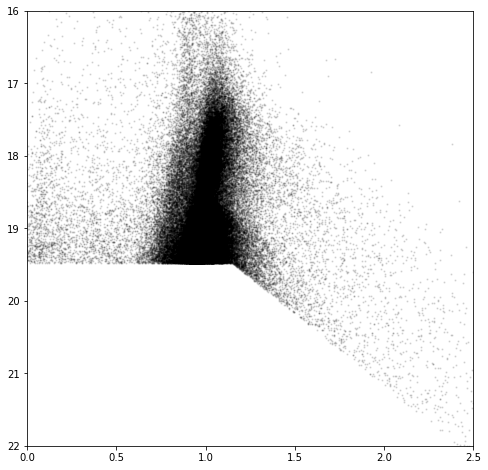

In [ ]:
fig, ax = plt.subplots(1)
fig.set_size_inches(8,8)

#ax.scatter(phatter.F110W_F160W.evaluate(), phatter.F160W_VEGA.evaluate(), c='grey', alpha=0.1)
ax.scatter(phatter.F110W_F160W.evaluate(selection='COL_CUT'), phatter.F160W_VEGA.evaluate(selection='COL_CUT'), 
           c='black',
          alpha=0.1,
          s=1.5)

ax.set_ylim(22,16);
ax.set_xlim(0,2.5);

In [ ]:
unwise['index'] = np.arange(len(unwise))

In [ ]:
rabins = np.linspace(23.34, 23.663, 300)
decbins = np.linspace(30.488, 30.851, 300)
pvals = np.arange(len(phatter.RA.evaluate(selection='COL_CUT')))
uvals = np.arange(len(unwise['ra']))


pstat = scipy.stats.binned_statistic_2d(phatter.RA.evaluate(selection='COL_CUT'), 
                                        phatter.DEC.evaluate(selection='COL_CUT'),
                                        (phatter.RA.evaluate(selection='COL_CUT'), 
                                        phatter.DEC.evaluate(selection='COL_CUT')),
                                        bins=300
                                                     )
ustat = scipy.stats.binned_statistic_2d(unwise['ra'], 
                                        unwise['dec'], 
                                        (unwise['ra'], 
                                        unwise['dec']),
                                        bins=300)

In [ ]:
np.max(pstat.binnumber), np.max(ustat.binnumber)

(90867, 90896)

In [ ]:
pbins, ubins = pstat.binnumber, ustat.binnumber

In [ ]:
unwise['bin'] = ubins

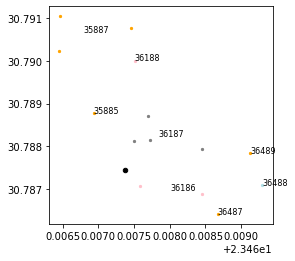

In [ ]:
fig, ax = plt.subplots(1)
fig.set_size_inches(4,4)

ax.scatter(unwise['ra'][500], unwise['dec'][500], c='black', s=20)

uw = unwise['bin'][500]
bins = [uw, uw+1, uw-1, uw+301, uw-301, uw+300, uw-300, uw+302, uw-302]
cols = ['grey', 'pink', 'pink', 'powderblue', 'powderblue', 'orange', 'orange', 'orange', 'orange']

for i,bin in enumerate(bins):
    loc, = np.where(phatter.BIN.evaluate(selection='COL_CUT') == bins[i])
    ax.scatter(phatter.RA.evaluate(selection='COL_CUT')[loc], phatter.DEC.evaluate(selection='COL_CUT')[loc],
               c=cols[i], s=5)
    if len(loc) != 0:
        ax.text(np.mean(phatter.RA.evaluate(selection='COL_CUT')[loc]), 
                np.mean(phatter.DEC.evaluate(selection='COL_CUT')[loc]),
                str(bins[i]), color='black', fontsize=8)
    else:
        pass

In [ ]:
match_ids = np.asarray(['****************'] * len(phatter))
bins = 300

for i,source in enumerate(unwise):
    wb = unwise['bin'][i]
    pbs = [wb - bins - 2, wb - bins - 1, wb - bins, wb - 1, wb, wb + 1, wb + bins, wb + bins + 1, wb + bins + 2]
    loc, = np.where((phatter.BIN.evaluate(selection='COL_CUT') == pbs[0]) |
                (phatter.BIN.evaluate(selection='COL_CUT') == pbs[1]) |
                (phatter.BIN.evaluate(selection='COL_CUT') == pbs[2]) |
                (phatter.BIN.evaluate(selection='COL_CUT') == pbs[3]) |
                (phatter.BIN.evaluate(selection='COL_CUT') == pbs[4]) |
                (phatter.BIN.evaluate(selection='COL_CUT') == pbs[5]) |
                (phatter.BIN.evaluate(selection='COL_CUT') == pbs[6]) |
                (phatter.BIN.evaluate(selection='COL_CUT') == pbs[7]) |
                (phatter.BIN.evaluate(selection='COL_CUT') == pbs[8])
               )
    
    """Distance of each HST source from WISE source [i]"""                                                                                                                                              
    dist = np.sqrt( ((phatter.RA.evaluate(selection='COL_CUT')[loc] 
                      - unwise['ra'][i])*np.cos(unwise['dec'][i] * np.pi / 180))**2 
                   + (phatter.DEC.evaluate(selection='COL_CUT')[loc] 
                      - unwise['dec'][i])**2)
    """Indicies of HST sources where the distance above is less than or equal to 6 arcsec"""                                                                                                                                              
    matched, = np.where(dist <= 6/3600)
  
    if len(matched) != 0:
        match_ids[matched] = unwise['unwise_objid'][i]
    else:
        pass

KeyboardInterrupt: 

In [ ]:
match, = np.where(match_ids != '****************')
n = 4
"""These are the first n unwise object IDs for sources that have matches"""
first_n = np.unique(match_ids[match])[:n]

In [ ]:
len(match), len(np.unique(match_ids[match]))

(264, 30)

<string>:1: RuntimeWarning: overflow encountered in power


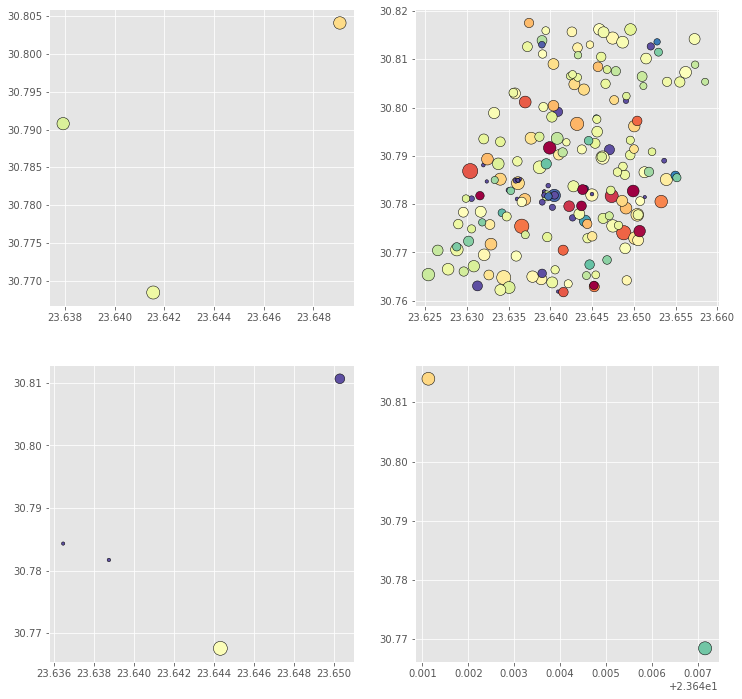

In [ ]:
plt.style.use('ggplot')
fig, axs = plt.subplots(2, 2, figsize=(12,12))
#fig.tight_layout(pad=3, h_pad=8)

dec_m33 = 30.66
aspect_ratio = np.cos(np.pi/180.*dec_m33)

for i,ax in enumerate(axs.ravel()):
  ws, = np.where(unwise['unwise_objid'] == first_n[i])
  wind = unwise['index'][ws]

  matches, = np.where((match_ids == first_n[i]))
  match_flux = phatter.W1_Flux.evaluate(selection='COL_CUT')[matches]
  total_flux = np.sum(phatter.W1_Flux.evaluate(selection='COL_CUT')[matches])
  wise_flux = unwise['flux_1'][wind]
  colors_match = phatter.F110W_F160W.evaluate(selection='COL_CUT')[matches]
  cmap = plt.cm.get_cmap('Spectral_r')
  ordered = np.argsort(match_flux)[::-1]
  max_ff = (match_flux[ordered][0] / total_flux).round(2)

  ax.errorbar(unwise[wind]['ra'], unwise[wind]['dec'], 
              xerr=(6/3600), yerr=(6/3600), ecolor='darkgrey', linewidth=2)
  ax.errorbar(unwise[wind]['ra'], unwise[wind]['dec'], 
              xerr=(3/3600), yerr=(3/3600), ecolor='grey', elinewidth=4)
  ax.scatter(unwise[wind]['ra'], unwise[wind]['dec'], s=wise_flux, c='white', label='WISE Source', zorder=5)
  ax.scatter(unwise[wind]['ra'], unwise[wind]['dec'], s=total_flux, edgecolors='black', linewidth=2, 
             facecolors='none', marker='o', linestyle=':', linewidths=2, label='Total Flux of Matches', zorder=6)
  cplot = ax.scatter(phatter.RA.evaluate(selection='COL_CUT')[matches], phatter.DEC.evaluate(selection='COL_CUT')[matches], 
                     s=match_flux, 
                     edgecolors='black', 
                     c=colors_match, 
                     cmap=cmap, 
                     vmin=0.75, vmax=1.35, 
                     label='HST Matches', 
                     zorder=7)
  


In [ ]:
filt, = np.where(phatter.W1_Flux.evaluate() > 0.0 )

In [ ]:
i = 0

ws, = np.where(unwise['unwise_objid'] == first_n[i])

matches, = np.where(match_ids[filt] == first_n[i])

#match_flux = phatter.W1_Flux.evaluate()[filt][matches]
#total_flux = np.sum(phatter.W1_Flux.evaluate()[filt][matches])
#wise_flux = unwise['flux_1'][ws]
#colors_match = phatter.F110W_F160W.evaluate()[filt][matches]
#cmap = plt.cm.get_cmap('Spectral_r')
#ordered = np.argsort(match_flux)[::-1]
#max_ff = (match_flux[ordered][0] / total_flux).round(2)

In [ ]:
first_n[i]

'0226p302o0019588'

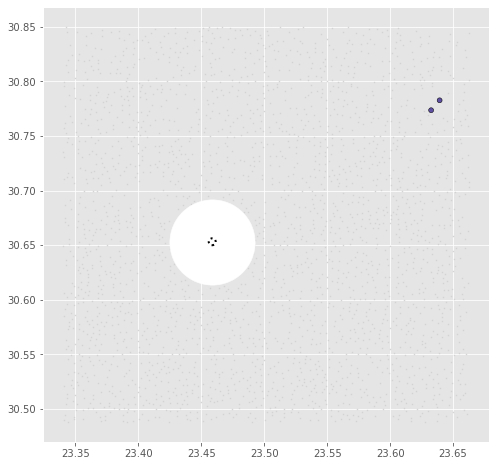

In [ ]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1,1, figsize=(8,8))

dec_m33 = 30.66
aspect_ratio = np.cos(np.pi/180.*dec_m33)


ax.scatter(unwise['ra'], unwise['dec'], c='lightgrey', s=1)
ax.errorbar(unwise[ws]['ra'], unwise[ws]['dec'], 
              xerr=(6/3600), yerr=(6/3600), color='darkgrey', linewidth=2)
ax.errorbar(unwise[ws]['ra'], unwise[ws]['dec'], 
              xerr=(3/3600), yerr=(3/3600), color='grey', linewidth=4)
ax.scatter(unwise[ws]['ra'], unwise[ws]['dec'], s=wise_flux, c='white', label='WISE Source', zorder=5)
ax.scatter(unwise[ws]['ra'], unwise[ws]['dec'], s=total_flux, edgecolors='black', linewidth=2, 
             facecolors='none', marker='o', linestyle=':', linewidths=2, label='Total Flux of Matches', zorder=6)
cplot = ax.scatter(phatter.RA.evaluate()[filt][matches], 
                   phatter.DEC.evaluate()[filt][matches], 
                     s=match_flux, 
                     edgecolors='black', 
                     c=colors_match, 
                     cmap=cmap, 
                     vmin=0.75, vmax=1.35, 
                     label='HST Matches', 
                     zorder=7)

In [ ]:
  x,y = unwise[wind]['ra'], unwise[wind]['dec']
  xticks, yticks = np.linspace(x-0.002, x+0.002, 6).round(5), np.linspace(y-0.002, y+0.002, 6).round(5)
  xlabels, ylabels = np.linspace(x-0.002, x+0.002, 6).round(5), np.linspace(y-0.002, y+0.002, 6).round(5)
  ax.set_xticks(xticks)
  ax.set_yticks(yticks)
  ax.set_xticklabels(xlabels, rotation=70)
  ax.set_yticklabels(ylabels)
  ax.set_xlabel('RA', fontsize=15)
  ax.set_ylabel('DEC', fontsize=15)
  ax.set_title('unWISE Index: ' + str(unwise['index'][j]), color='black')
  ax.text(x-0.0019, y-0.0019, str(max_ff), fontsize=15)
  ax.set_aspect(aspect_ratio)
  plt.colorbar(cplot, ax=ax, label='F110W-F160W')
  
labels_handles = {
  label: handle for ax in fig.axes for handle, label in zip(*ax.get_legend_handles_labels())
}

fig.legend(
  labels_handles.values(),
  labels_handles.keys(),
  loc="upper center",
  bbox_to_anchor=(0.5, 0),
  bbox_transform=plt.gcf().transFigure,
  fontsize=20, markerscale=1, fancybox=True
); 

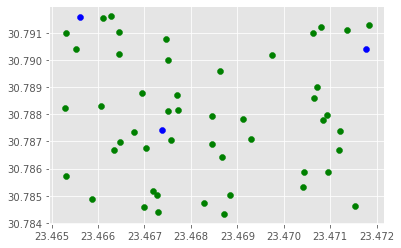

In [ ]:
i = 1061

fig, ax = plt.subplots(1)

u, = np.where(unwise['bin'] == i)
p, = np.where(phatter.BIN.evaluate(selection='COL_CUT') == i)

ax.scatter(phatter.RA.evaluate(selection='COL_CUT')[p], phatter.DEC.evaluate(selection='COL_CUT')[p], c='green')
ax.scatter(unwise['ra'][u], unwise['dec'][u], c='blue');

In [ ]:
unwise['bin'][500]

1061